## Udacity Set to Coco

In [1]:
import sys
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
print(sys.path)

['', '/home/dean/anaconda3/envs/ros-kache/lib/python35.zip', '/home/dean/anaconda3/envs/ros-kache/lib/python3.5', '/home/dean/anaconda3/envs/ros-kache/lib/python3.5/plat-linux', '/home/dean/anaconda3/envs/ros-kache/lib/python3.5/lib-dynload', '/home/dean/.local/lib/python3.5/site-packages', '/home/dean/anaconda3/envs/ros-kache/lib/python3.5/site-packages', '/home/dean/anaconda3/envs/ros-kache/lib/python3.5/site-packages/IPython/extensions', '/home/dean/.ipython']


In [2]:
## Imports

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from PIL import Image

import scipy.misc
from skimage import measure   

import time
import os
import zipfile as zf
import tarfile
import csv
import pickle
import urllib
import pandas as pd

/home/dean/anaconda3/envs/ros-kache/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
## Dataset Parameters ##
TRAINING_DATASET_DIRECTORY = 'training-set/'
WORKING_DIRECTORY = '/media/dean/49D9D6EB1BE53FC4/datasets/UdacityDrive/object-detection-crowdai/'
OBJ_NEGATIVES_TOKEN = 'non_objects'
dataset_path = "{}{}{}{}".format(WORKING_DIRECTORY, TRAINING_DATASET_DIRECTORY,'**/', '*.png')
DATACACHE_DIRECTORY = os.path.join(WORKING_DIRECTORY, 'datacache/')


## Udacity Dataset Extraction Parameters ##
UDACITY_ANNS_CSV = os.path.join(WORKING_DIRECTORY, 'labels_small.csv')
HEADER_ROW=['xstart', 'ystart', 'xstop', 'ystop', 'frame', 'label', 'preview_url']
UDACITY_SOURCE_URL = 'http://bit.ly/udacity-annoations-crowdai'
DATASET_ZIPFILE = 'object-detection-crowdai.tar.gz'
OVERWRITE_UDACITY_DATASET = False

UDACITY_DATASET_DIRECTORY = os.path.join(WORKING_DIRECTORY, TRAINING_DATASET_DIRECTORY, 'udacity-set') 
APPEND_UDACITY_DATASET = True
UDACITY_AUGMENT_PCT = 0.99

## RoadCOCO Dataset Labels
RoadCOCO_LABELS_PATH = os.path.join(WORKING_DIRECTORY, '../','RoadCOCO_Classes.csv')
GT_HEADER_ROW = ['class', 'super-category', 'special', 'description']

## Image Processing ##
DEFAULT_WIDTH, DEFAULT_LENGTH, DEFAULT_DEPTH = (448, 448, 3)
DEFAULT_RESOLUTION = (DEFAULT_LENGTH, DEFAULT_WIDTH, DEFAULT_DEPTH)
if DEFAULT_DEPTH == 1:
    DEFAULT_RESOLUTION = DEFAULT_RESOLUTION[:-1]
    
## Training Parameters ##
OVERWRITE_DATACACHE = True

### Helper Functions - Udacity Dataset Loading & Augmentation

In [4]:
# Define a function to scale .PNG and JPEG Files both to 0 to 1 
def normalize_pixels(img):
    max_pixel_value = np.max(img)
    if max_pixel_value > 1.0:
        img = np.copy(np.subtract(np.divide(img, 255.0), 0.5)).astype(np.float64)
    return img

# Define a function to scale .PNG and JPEG Files both to 0 to 1 
def denormalize_pixels(img):
#     print('Denormalize Pixels: Max pixel Value', np.max(img))
#     print('Denormalize Pixels: Min pixel Value', np.min(img))  
    
    img = np.copy(np.multiply(np.add(img,0.5), 255.0)).astype(np.int32)
#     max_pixel_value = np.max(img)
#     if np.min(img) <= 0.0 or np.max(img) <= 1.0:
#     print('Denormalize Pixels: Max pixel Value_Scaled', np.max(img))
#     print('Denormalize Pixels: Min pixel Value_Scaled', np.min(img))   
    
    assert np.min(img) >= 0
    assert np.max(img) <= 255
    return img

def process_img(filepath):
    image = cv2.imread(filepath)
#     print('Process Image: Max pixel Value', np.max(image))
#     print('Process Image: Min pixel Value', np.min(image))
    img_copy = image.copy()
    img_copy = cv2.cvtColor(img_copy,cv2.COLOR_BGR2RGB)
    img_copy = img_copy/255.-.5 
#     print('Process Image: Max pixel Value_Scaled', np.max(img_copy))
#     print('Process Image: Min pixel Value_Scaled', np.min(img_copy))
    return img_copy

In [5]:
def maybe_download(source_url, filename):
    if not os.path.exists(WORKING_DIRECTORY):
        os.mkdir(WORKING_DIRECTORY)
    
    filepath = os.path.join(WORKING_DIRECTORY, filename)
    if not os.path.exists(filepath):
        filepath, _ = urllib.request.urlretrieve(source_url, filepath)
        statinfo = os.stat(filepath)
        print('')
        print('Succesfully downloaded:', filepath, '| % d MB.' % int(statinfo.st_size*1e-6))
    return filepath

In [6]:
def unzip_file(zip_file, source_dir_name=None, destination=WORKING_DIRECTORY):
    if 'tar.gz' in zip_file:
        head, tail = os.path.splitext(zip_file)
        if not os.path.exists(os.path.join(os.path.splitext(head)[0])):
            print('unzipping file:', zip_file, 'to directory:', os.path.join( os.path.splitext(head)[0]))
            tar = tarfile.open(zip_file, "r:*")
            tar.extractall(destination)
            tar.close()
    else: #.zip extension
        head, tail = os.path.splitext(zip_file)
        #print('Target Dir', os.path.join(destination, head))
        if not os.path.exists(os.path.join(destination, head)):
            print('File does not exist: ', os.path.join(destination, head), ': Extracting')
            zipf = zf.ZipFile(os.path.join(WORKING_DIRECTORY,zip_file))
            print('Loaded zipf',zipf, ': Extracting')
            zipf.extractall(os.path.join(destination, head))
            zipf.close()

In [7]:
def extract_and_preprocess_image(filepath, objs_dir, nonobjs_dir, xstart, ystart, xstop, ystop, obj_class,
                                 img_size=(DEFAULT_LENGTH, DEFAULT_WIDTH), img_ext = '.png'):
    full_path = os.path.join(WORKING_DIRECTORY, 'object-detection-crowdai', filepath)
#     print('Processing: ', full_path)
    
    # Image read in from cv2 + .jpg -> (0 to 1)
    if os.path.exists(full_path) or OVERWRITE_UDACITY_DATASET == True:
        # Use cv2 to open image and extract bounding boxes
        img = process_img(full_path)
        img_height, img_width = img.shape[:2]
#         print('img_width_x: ', img_width, 'img_height_y: ',img_height)
        # boxed_img = im[y:y+h,x:x+w]
        # Extract Image. Note: numpy arrays are (row, col)!
        
#         print('ystart:ystop, xstart:xstop:', ystart,':',ystop,xstart,':',xstop)
        # Add Offests to allow for Object Detection Tasks
        offset = 20
        xstart_mod, ystart_mod, xstop_mod, ystop_mod =  (0 if xstart-offset <= 0 else xstart-offset), \
                                                        (0 if ystart-offset <= 0 else ystart-offset), \
                                                        (img_width if xstop+offset > img_width else xstop+offset), \
                                                        (img_height if ystop+offset > img_height else ystop+offset)
            
#         print('ystart_mod:ystop_mod, xstart_mod:xstop_mod:', ystart_mod,':',ystop_mod,xstart_mod,':',xstop_mod)
        detection = img[ystart_mod:ystop_mod, xstart_mod:xstop_mod]
        resized_detection = cv2.resize(detection, img_size, interpolation=cv2.INTER_AREA)
        denorm = denormalize_pixels(resized_detection)        

        
#         obj_img = Image.fromarray(denorm)
        
        # Save Detected Object Image with offsets
        filename, ext = os.path.splitext(filepath)
        new_filename =  "{}_{}_{}_{}_{}_{}{}".format(filename,obj_class, xstart, ystart, xstop, ystop, img_ext)
#         print('Saving image: ', filename)
        scipy.misc.imsave(os.path.join(objs_dir, new_filename), denorm)
        
        
        ## TODO: Create Segmentation map and save that under annotations.
        
        ## Feed Segmentation coordinates into Coco Dataset
        
        
        ## (Optional) Auto-Generate 'Negative Class' Labels to keep dataset balanced
        i_lrc = np.random.randint(3) # 66% chance of auto generating non-obj features
        if (i_lrc > 1):
            try:
                # Estimate Negative Label as crop surrounding the Positive Detections
                xstart_mod, ystart_mod, xstop_mod, ystop_mod = xstart, \
                                                        (0 if ystart-(ystop-ystart) < 0 else ystart-(ystop-ystart)), xstop, ystart
                new_filename =  "{}_{}_{}_{}_{}_{}{}".format(filename,'non_'+obj_class.lower(), xstart_mod, ystart_mod, xstop_mod, ystop_mod, img_ext)
                path_file = os.path.join(nonobjs_dir, new_filename)


                nonobj_img = img[ystart_mod:ystop_mod, xstart_mod:xstop_mod]
                resized_nonobj_img = cv2.resize(nonobj_img, img_size, interpolation=cv2.INTER_AREA)

                # Save Negative Label
                scipy.misc.imsave(path_file, resized_nonobj_img)
            except:
                print("Error saving negative label:", path_file, " Moving on..")

In [8]:
## Download Udacity Dataset
tar_file = maybe_download( UDACITY_SOURCE_URL, os.path.join(WORKING_DIRECTORY,DATASET_ZIPFILE))
unzip_file(tar_file)
                    
cars_dir = os.path.join(UDACITY_DATASET_DIRECTORY, 'cars')
trucks_dir = os.path.join(UDACITY_DATASET_DIRECTORY, 'trucks')
peds_dir = os.path.join(UDACITY_DATASET_DIRECTORY, 'pedestrians')

# Make Directory for Negative Annotations
nonobjs_dir = os.path.join(UDACITY_DATASET_DIRECTORY, OBJ_NEGATIVES_TOKEN)
noncars_dir = os.path.join(nonobjs_dir, 'non_cars')
nontrucks_dir = os.path.join(nonobjs_dir, 'non_trucks')
nonpeds_dir = os.path.join(nonobjs_dir, 'non_peds')

# Create Directories to store images for Pre-processing
os.makedirs(cars_dir, exist_ok=True)
os.makedirs(trucks_dir, exist_ok=True)
os.makedirs(peds_dir, exist_ok=True)
os.makedirs(noncars_dir, exist_ok=True)
os.makedirs(nontrucks_dir, exist_ok=True)
os.makedirs(nonpeds_dir, exist_ok=True)

In [9]:
## Extract Labels ##
annotations = pd.read_csv(UDACITY_ANNS_CSV, names=HEADER_ROW, skiprows=1)
annotations.head()

,xstart,ystart,xstop,ystop,frame,label,preview_url
0,785,533,905,644,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
1,89,551,291,680,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
2,268,546,383,650,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
3,455,522,548,615,1479498371963069978.jpg,Truck,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
4,548,522,625,605,1479498371963069978.jpg,Truck,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...


In [10]:
# ## Extract Labels ##      
# for label in annotations.as_matrix():
#     filename, ext = os.path.splitext(label[4])
#     new_filename =  "{}_{}_{}_{}_{}_{}{}".format(filename,label[5].lower(), label[0], label[1], label[2], label[3], '.png')
    
#     for obj_class in set(annotations['label'].tolist()):
#         if not os.path.exists(os.path.join(cars_dir, new_filename)) and label[5].lower() == obj_class.lower():
#             extract_and_preprocess_image(label[4], cars_dir, noncars_dir, xstart=label[0], ystart=label[1],
#                                          xstop=label[2], ystop=label[3], obj_class=obj_class)
#         elif not os.path.exists(os.path.join(trucks_dir, new_filename)) and label[5].lower() == obj_class.lower():
#             extract_and_preprocess_image(label[4], trucks_dir, nontrucks_dir, xstart=label[0], ystart=label[1],
#                                          xstop=label[2], ystop=label[3], obj_class=obj_class)
#         elif not os.path.exists(os.path.join(peds_dir, new_filename)) and label[5].lower() == obj_class.lower():
#             extract_and_preprocess_image(label[4], peds_dir, nonpeds_dir, xstart=label[0], ystart=label[1],
#                                          xstop=label[2], ystop=label[3], obj_class=obj_class)

In [11]:
def PolyArea(x,y):
    ## Investigate why this works
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

In [12]:
# # Script to convert Udacity Drive Annotations to Coco Json Annotations
# import xml.etree.cElementTree as ET
# import glob
# import argparse
# import os
# import numpy as np
# import json
# import numpy
# import cv2
# from collections import OrderedDict
# from shapely.geometry import Polygon, MultiPolygon

# from PIL import Image
# annotations = pd.read_csv(UDACITY_ANNS_CSV, names=HEADER_ROW, skiprows=1)

# category_ids = OrderedDict()
# for i, label in enumerate(sorted(set(annotations['label'].tolist()))):
#     category_ids[label] = i

# images, anns = [], []
# img_paths = set(annotations['frame'].tolist())

# num_imgs = len(img_paths)

# for i, f in enumerate(sorted(img_paths)):

#     im = Image.open(os.path.join(WORKING_DIRECTORY, f))
#     width, height = im.size
#     dic = {'file_name': f, 'id': i, 'height': height, 'width': width}
#     images.append(dic)

# ann_index = 0


#     ## Create Sub-Mask
#     heatmap = np.zeros_like(img[:,:,0])    
#     for window in windows:
#         test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], 
#                               (DEFAULT_LENGTH, DEFAULT_WIDTH)) 
#         #4) Extract features for that window using single_img_features()
#         features = single_img_features(test_img)
#         #5) Scale extracted features to be fed to classifier
#         test_features = X_scaler.transform(list(np.array(features).reshape(1, -1)))
#         #6) Predict using classifier
#         prediction = svc.predict(test_features)
#         #7) If positive (prediction == 1) then save the window
#         if prediction == 1: # Car detected
#             on_windows.append(window)
#             heatmap[window[0][1]:window[1][1], window[0][0]:window[1][0]] +=1
            
            

# for i, annotation in enumerate(annotations.as_matrix()):
#     # xy coords: [xstart, ystart, xstop, ystop] -> bbox = [x,y,width,height]
#     xstart, ystart, xstop, ystop = annotation[0], annotation[1], \
#                                    annotation[2], annotation[3]

#     contours = numpy.array([[xstart, ystart],[xstop, ystart],[xstop, ystop],[xstart, ystop]], dtype=numpy.float64)
#     im = Image.open(os.path.join(WORKING_DIRECTORY, annotation[4]))
#     width, height = im.size
#     im.close
    
    
#     drawing = numpy.zeros([width, height],numpy.uint8)
#     for cnt in contours:
#         ctr = numpy.array(cnt).reshape((-1,1,2)).astype(numpy.int32)
#         cv2.drawContours(drawing, [ctr], 0, (0, 255, 0), 2)
#         #cv2.drawContours(drawing,cnt,0,(255,255,255),2)
    
#     segmentations = []
#     polygons = []
#     for contour in contours:
# #         # Flip from (row, col) representation to (x, y)
# #         # and subtract the padding pixel
# #         for i in range(len(contour)):
# #             row, col = contour[i]
# #             contour[i] = (col - 1, row - 1)

#         # Make a polygon and simplify it
#         poly = Polygon(contour)
#         poly = poly.simplify(1.0, preserve_topology=False)
#         polygons.append(poly)
#         segmentation = np.array(poly.exterior.coords).ravel().tolist()
#         segmentations.append(segmentation)

#     # Combine the polygons to calculate the bounding box and area
#     multi_poly = MultiPolygon(polygons)
#     x, y, max_x, max_y = multi_poly.bounds
#     width = max_x - x
#     height = max_y - y
#     bbox = (x, y, width, height)
#     area = multi_poly.area

#     annotation = {
#         'segmentation': segmentations,
#         'iscrowd': is_crowd,
#         'image_id': image_id,
#         'category_id': category_id,
#         'id': annotation_id,
#         'bbox': bbox,
#         'area': area
#     }

#     ann_index+=1
#     anns.append(annotation) 



# #     ## Hard Code BBox coordinate for now, later I will estimate the Bboxes from the largest rectangle from Segmentation Coordinates
# #     x, y, w, h = xstart, ystart, (xstop-xstart), (ystop-ystart)
# #     bbox = [x, y, w, h]
# #     xs = [xstart, xstop, xstop, xstart]
# #     ys = [ystart, ystart, ystop, ystop]
    
    
# #     # List of (x,y) coordinates
# #     poly = [(xstart, ystart), (xstop, ystart), (xstop, ystop), (xstart, ystop)]
# #     area = PolyArea(xs,ys)
    
# #     image_dic = set([img['id'] for img in images if img['file_name'] == annotation[4].lower()])
    
# #     dic2 = {'segmentation': poly, 'area': area, 'iscrowd': 0, 'image_id':image_dic.pop(), 'bbox':bbox, 'category_id': category_ids[annotation[5]], 'id': i}
# #     ann_index+=1
# #     anns.append(dic2)


In [13]:
## Get Category IDs - Use RoadCOCO as a template
# Get RoadCOCO Labels
gt_labels = pd.read_csv(RoadCOCO_LABELS_PATH, names=GT_HEADER_ROW, skiprows=1)
gt_labels.head()

,class,super-category,special,description
0,Vehicle,Vehicle,Orientation matters,Combination of all other vehicles to get a cat...
1,Car,Vehicle,Orientation matters,NaN
2,Pickup,Truck,Orientation matters,NaN
3,TractorSemi,Truck,Orientation matters,NaN
4,TrailerSemi,Truck,Orientation matters,NaN


In [14]:
from collections import defaultdict

# Represent Category IDs using RoadCOCO Labels
cats2ids = {}

for i, label in enumerate(sorted(set(gt_labels['class'].tolist()))):
    cats2ids[str(label).lower()] = i
ids2cats = {i: v for v, i in cats2ids.items()}
    


# Build Categories List in MS Coco Format
coco_categories = []
    
for label in gt_labels.as_matrix():
    category = str(label[0]).lower()
    cat_id = cats2ids[category]
    
    
    # Verify super-category in list, handle edge cases
    if str(label[1]).lower() == 'truck':
        sup_cat = ids2cats[cats2ids['utilitytruck']]
    elif str(label[1]).lower() == 'constructionfurniture':
        sup_cat = ids2cats[cats2ids['constructionequipment']]
    elif str(label[1]).lower() == 'pedestrian':
        sup_cat = ids2cats[cats2ids['person']]
    else:
        sup_cat = ids2cats[cats2ids[str(label[1]).lower()]]
    
    coco_categories.append({"id": cat_id, "name": category, "supercategory":sup_cat})

# for category, cat_id in cats2ids.items():
#     # Get supercategory
#     #sup_cat = gt_labels.loc[[category],['category']]
#     #sup_cat = df2.loc['class', category] 
#     #sup_cat = gt_labels[pd.Series(gt_labels.index).str.contains(category, case=False)]

#     #print('Cat:',category,'Sup_Cat:',sup_cat)
    
#     if not sup_cat:
#         sup_cat = 'misc_label'
#     # Append New Category to Coco Categories
#     coco_categories.append({"id": cat_id, "name": category, "supercategory":sup_cat})
    
print (coco_categories)

[{'supercategory': 'vehicle', 'name': 'vehicle', 'id': 62}, {'supercategory': 'vehicle', 'name': 'car', 'id': 8}, {'supercategory': 'utilitytruck', 'name': 'pickup', 'id': 37}, {'supercategory': 'utilitytruck', 'name': 'tractorsemi', 'id': 52}, {'supercategory': 'utilitytruck', 'name': 'trailersemi', 'id': 60}, {'supercategory': 'utilitytruck', 'name': 'firetruck', 'id': 21}, {'supercategory': 'utilitytruck', 'name': 'ambulance', 'id': 0}, {'supercategory': 'vehicle', 'name': 'police', 'id': 39}, {'supercategory': 'constructionequipment', 'name': 'constructionequipment', 'id': 10}, {'supercategory': 'vehicle', 'name': 'motorcycle', 'id': 34}, {'supercategory': 'person', 'name': 'scooter', 'id': 43}, {'supercategory': 'vehicle', 'name': 'bicyclist', 'id': 4}, {'supercategory': 'vehicle', 'name': 'escooter', 'id': 20}, {'supercategory': 'misc_label', 'name': 'skateboard', 'id': 45}, {'supercategory': 'person', 'name': 'wheelchair', 'id': 64}, {'supercategory': 'person', 'name': 'stroller

/home/dean/anaconda3/envs/ros-kache/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [15]:
# Script to convert Udacity Drive Annotations to Coco Json Annotations
import xml.etree.cElementTree as ET
import glob
import argparse
import os
import numpy as np
import json
import numpy
import cv2
from collections import OrderedDict
from shapely.geometry import Polygon, MultiPolygon

from PIL import Image
annotations = pd.read_csv(UDACITY_ANNS_CSV, names=HEADER_ROW, skiprows=1)


images, anns = [], []
img_paths = set(annotations['frame'].tolist())

num_imgs = len(img_paths)
ann_index = 0
    
for img_id, f in enumerate(sorted(img_paths)):                   
    for annotation in [x for x in annotations.as_matrix() if x[4].lower() == f.lower()]:

        im = Image.open(os.path.join(WORKING_DIRECTORY, f))
        width, height = im.size
        dic = {'file_name': f, 'id': img_id, 'height': height, 'width': width}
        images.append(dic)
        
        # xy coords: [xstart, ystart, xstop, ystop] -> bbox = [x,y,width,height]
        xstart, ystart, xstop, ystop = annotation[0], annotation[1], \
                                       annotation[2], annotation[3]        
        binary_mask = np.zeros_like(im)[:,:,0]
        binary_mask[xstart:xstop, ystart:ystop] +=1
        
        
        contours = measure.find_contours(binary_mask, 0.5, positive_orientation='low')
        polygons = []
        segmentations = []

        for contour in contours:
            # Flip from (row, col) representation to (x, y)
            # and subtract the padding pixel
#             for i in range(len(contour)):
#                 row, col = contour[i]
#                 contour[i] = (col - 1, row - 1)

            # Make a polygon and simplify it
            poly = Polygon(contour)
            poly = poly.simplify(1.0, preserve_topology=False)
            
            if poly and poly.exterior:
                polygons.append(poly)
                segmentation = np.array(poly.exterior.coords).ravel().tolist()
                segmentations.append(segmentation)

        # Combine the polygons to calculate the bounding box and area
        multi_poly = MultiPolygon(polygons)
        if multi_poly.bounds:
            x, y, max_x, max_y = multi_poly.bounds
            width = max_x - x
            height = max_y - y
            bbox = (x, y, width, height)
            area = multi_poly.area
            
            # Get Label
            if annotation[5].lower() in cats2ids.keys():
                category = cats2ids[annotation[5].lower()]
            else:
                # Flag data point for relabeling
                category = cats2ids['misc_label']

            annotation = {
                'segmentation': segmentations,
                'iscrowd': 0,
                'image_id': img_id,
                'category_id': category,
                'id': ann_index,
                'bbox': bbox,
                'area': area
            }

            ann_index+=1
            anns.append(annotation) 




/home/dean/anaconda3/envs/ros-kache/lib/python3.5/site-packages/ipykernel/__main__.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [16]:
#print(anns[:1000])
print(anns)

[{'id': 0, 'bbox': (784.5, 532.5, 120.0, 111.0), 'image_id': 0, 'category_id': 8, 'segmentation': [[904.5, 643.0, 904.0, 532.5, 784.5, 533.0, 785.0, 643.5, 904.5, 643.0]], 'iscrowd': 0, 'area': 13205.0}, {'id': 1, 'bbox': (88.5, 550.5, 202.0, 129.0), 'image_id': 0, 'category_id': 8, 'segmentation': [[290.5, 679.0, 290.0, 550.5, 88.5, 551.0, 89.0, 679.5, 290.5, 679.0]], 'iscrowd': 0, 'area': 25893.0}, {'id': 2, 'bbox': (267.5, 545.5, 115.0, 104.0), 'image_id': 0, 'category_id': 8, 'segmentation': [[382.5, 649.0, 382.0, 545.5, 267.5, 546.0, 268.0, 649.5, 382.5, 649.0]], 'iscrowd': 0, 'area': 11851.0}, {'id': 3, 'bbox': (454.5, 521.5, 93.0, 93.0), 'image_id': 0, 'category_id': 31, 'segmentation': [[547.5, 614.0, 547.0, 521.5, 454.5, 522.0, 455.0, 614.5, 547.5, 614.0]], 'iscrowd': 0, 'area': 8556.5}, {'id': 4, 'bbox': (547.5, 521.5, 77.0, 82.5), 'image_id': 0, 'category_id': 31, 'segmentation': [[624.5, 604.0, 624.5, 522.0, 548.0, 521.5, 547.5, 604.0, 624.5, 604.0]], 'iscrowd': 0, 'area': 

In [17]:
from datetime import datetime
INFO = {
    "description": "Road Object-Detections Dataset based on MS COCO",
    "url": "https://kache.ai",
    "version": "0.0.1",
    "year": 2018,
    "contributor": "deanwebb",
    "date_created": datetime.utcnow().isoformat(' ')
}

LICENSES = [
    {
        "id": 1,
        "name": "The MIT License (MIT)",
        "url": "https://opensource.org/licenses/MIT",
        "description":  """
                        The MIT License (MIT)
                        Copyright (c) 2017 Matterport, Inc.

                        Permission is hereby granted, free of charge, to any person obtaining a copy
                        of this software and associated documentation files (the "Software"), to deal
                        in the Software without restriction, including without limitation the rights
                        to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
                        copies of the Software, and to permit persons to whom the Software is
                        furnished to do so, subject to the following conditions:

                        The above copyright notice and this permission notice shall be included in
                        all copies or substantial portions of the Software.

                        THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
                        IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
                        FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
                        AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
                        LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
                        OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
                        THE SOFTWARE.
                        """
    }
]

coco_output = {'info': INFO, 'licenses': LICENSES, 'images':images, 'annotations':anns, 'categories': coco_categories}
with open('{}/instances_shape_train2018.json'.format(WORKING_DIRECTORY), 'w') as output_json_file:
    json.dump(coco_output, output_json_file)

In [18]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

In [19]:
image_directory = WORKING_DIRECTORY
annotation_file = os.path.join(WORKING_DIRECTORY,'instances_shape_train2018.json')

In [20]:
example_coco = COCO(annotation_file)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [24]:
categories = example_coco.loadCats(example_coco.getCatIds())
category_names = [category['name'] for category in categories]
print('Custom COCO categories: \n{}\n'.format(' '.join(category_names)))

category_names = set([category['supercategory'] for category in categories])
print('Custom COCO supercategories: \n{}'.format(' '.join(category_names)))

Custom COCO categories: 
vehicle car pickup tractorsemi trailersemi firetruck ambulance police constructionequipment motorcycle scooter bicyclist escooter skateboard wheelchair stroller snowplow attenuatortruck garbagetruck deliverytruck boxtruck bus articulatedbus schoolbus metermaid utilitytruck shoppingcart person constructionworker trafficofficer garbagecan garbagebin snowfence mobilefence foldingbarricade dumpster mobilebathroom stopsign slowsign speedlimitsign trafficsign flare botsdots retroreflector pothole dog deer cow horse livestock otheranimal wheel debrisdrivable debrisnondrivable barrel pole cone constructionsign median trafficlightgeneral trafficlightgreen trafficlightred trafficlightamber trafficlightother misc_label

Custom COCO supercategories: 
trafficsign person constructionequipment utilitytruck vehicle misc_label


In [27]:
category_ids = example_coco.getCatIds(catNms=['square'])
image_ids = example_coco.getImgIds(catIds=category_ids)
image_data = example_coco.loadImgs(image_ids[np.random.randint(0, len(image_ids))])[0]
print(image_data)

{'height': 1200, 'file_name': '1479498384442876688.jpg', 'id': 16, 'width': 1920}


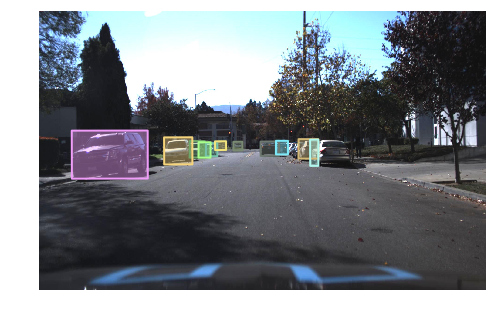

In [28]:
# load and display instance annotations
image = io.imread(os.path.join(image_directory ,image_data['file_name']))
plt.imshow(image); plt.axis('off')
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
annotation_ids = example_coco.getAnnIds(imgIds=image_data['id'], catIds=category_ids, iscrowd=None)
annotations = example_coco.loadAnns(annotation_ids)
example_coco.showAnns(annotations)